참고 문헌

1. https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
 
2. ImageNet Classification with Deep Convolutional Neural Networks


* TensorFlow: An open-source platform for the implementation, training, and deployment of machine learning models.
* Keras: An open-source library used for the implementation of neural network architectures that run on both CPUs and GPUs.
* Matplotlib: A visualization python tool used for illustrating interactive charts and images.

#### cf. TensorFlow vs. Pytorch

TensorFlow는 static, Pytorch는 Dynamic

# Implementing AlexNet CNN Architecture Using TensorFlow 2.0+ and Keras

Keras에서 제공하는 CIFAR-10 이미지 데이터를 이용하여 AlexNet을 구현해보는 과정이다.

CIFAR-10의 이미지 데이터는 10개의 class로 이루어져 있고, 각 class마다 12000개의 이미지가 들어있다. 또한 이미지의 형태는 rgb3개의 채널을 가지며, 가로세로 32x32 pixel로 상당히 크기가 작은 편이다. AlexNet은 227x227의 이미지를 이용하여 만들어 졌으므로 전처리를 하여 크기를 맞춰줄 것이다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [2]:
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

## 1. Dataset 훈련용 데이터 준비

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [4]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [6]:
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)
# validation_labels = to_categorical(validation_labels)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [8]:
train_labels.shape

(45000, 1)

## 2. Preprocessing 전처리 

각 이미지의 크기를 조절해줄 함수 process_images 정의

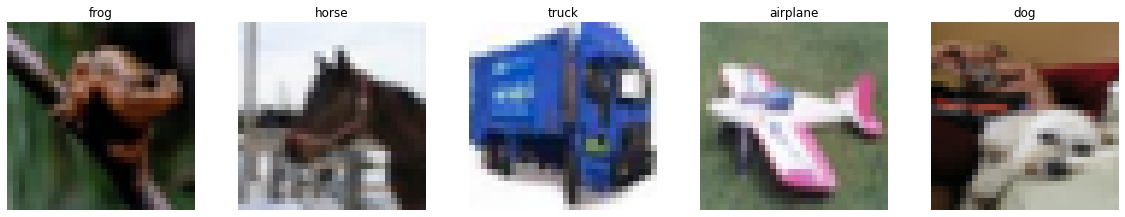

In [9]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [10]:
# def process_images(image, label):
#     # Normalize images to have a mean of 0 and standard deviation of 1
#     image = tf.image.per_image_standardization(image)
#     # Resize images from 32x32 to 277x277
#     image = tf.image.resize(image, (227,227))
#     return image, label

## 3. Input/data Pipeline

전처리가 완료된 60000개의 이미지 데이터를 무작위로 훈련용 데이터, 시험 데이터, 검증 데이터로 나눌 것이다. 그 비율은 9 : 2 : 1 이다.

또한 배치화 하여 학습할것이기 때문에 데이터 셋을 크기가 32인 배치로 나누어 준다.

In [11]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [12]:
train_ds = (train_ds
                  #.map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  #.map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  #.map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

In [13]:
train_ds.scan

AttributeError: 'BatchDataset' object has no attribute 'scan'

In [ ]:
test_ds.scan

In [ ]:
validation_ds.scan

## 3. Model Implementation

AlexNet은 CNN(Convolutional Nueral Network)으로 5개의 CNN Layer, 3개의 FC Layer(완전연결 계층)로 구성되어 있다.더 자세하게는 Convolutional layer, Batch Normalization layer, MaxPooling layer, Flatten layer, Dense layer의 층으로 이루어져 있다. 
여기서 flatten layer는 계산속도를 빠르게 하기 위해서 사용된다.

AlexNet의 특징은 다음과 같다.
1. ReLu활성화 함수 사용
2. Local Normalization 사용 - 같은 층의 서로다른 커널맵(특징맵)을 정규화했다. 
3. Overlapping Pooling - Max Pooling을 사용했는데 window의 크기는 3x3, stride는 2로 window가 겹치도록 했다.
4. Droput 사용 (with probability 0.5.)

* **Convolutional layer**: A convolution is a mathematical term that describes a dot product multiplication between two sets of elements. Within deep learning the convolution operation acts on the filters/kernels and image data array within the convolutional layer. Therefore a convolutional layer is simply a layer the houses the convolution operation that occurs between the filters and the images passed through a convolutional neural network.

In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', padding="same", input_shape=(32,32,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

## 5. Tensor Board

TensorFlow에서는 Tensor Board라고 하는 시각화 툴을 제공한다. 모델을 만들고 디버깅하거나, 학습 정도를 확인할때 유용하다.

In [15]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## 6. Training and Results

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         8

In [ ]:
model.fit(train_ds,
          epochs=10,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/10
   1/1406 [..............................] - ETA: 0s - loss: 2.5083 - accuracy: 0.1250WARNING:tensorflow:From C:\Users\fibik\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 467/1406 [========>.....................] - ETA: 6:24 - loss: 2.3972 - accuracy: 0.1463